In [3]:
#import libraries
import pennylane as qml
import torch
import torch.autograd
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
import math
from torchvision import transforms, utils
%matplotlib notebook
import matplotlib.pyplot as plt
import pennylane.templates.embeddings as embedding

#import pennylane.templates.layers as qmll
#from torch.autograd import Variable

In [4]:
# looking at the data
datas = pd.read_csv('iris-species\Iris.csv')

In [5]:
datas.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
datas.iloc[:,1:-1].head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [7]:
datas.iloc[:,-1]

0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
5         Iris-setosa
6         Iris-setosa
7         Iris-setosa
8         Iris-setosa
9         Iris-setosa
10        Iris-setosa
11        Iris-setosa
12        Iris-setosa
13        Iris-setosa
14        Iris-setosa
15        Iris-setosa
16        Iris-setosa
17        Iris-setosa
18        Iris-setosa
19        Iris-setosa
20        Iris-setosa
21        Iris-setosa
22        Iris-setosa
23        Iris-setosa
24        Iris-setosa
25        Iris-setosa
26        Iris-setosa
27        Iris-setosa
28        Iris-setosa
29        Iris-setosa
            ...      
120    Iris-virginica
121    Iris-virginica
122    Iris-virginica
123    Iris-virginica
124    Iris-virginica
125    Iris-virginica
126    Iris-virginica
127    Iris-virginica
128    Iris-virginica
129    Iris-virginica
130    Iris-virginica
131    Iris-virginica
132    Iris-virginica
133    Iris-virginica
134    Iri

In [8]:
datas.iloc[5,:].as_matrix()

C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([6, 5.4, 3.9, 1.7, 0.4, 'Iris-setosa'], dtype=object)

In [9]:
datas['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [10]:
datas = datas.replace('Iris-setosa',-1)
datas = datas.replace('Iris-virginica',1)
datas = datas.replace('Iris-versicolor',2)

datas = datas[datas.iloc[:,-1] != 2]

Xs = datas.iloc[:,1:-1]
labels = datas.iloc[:,-1]

idx = 0

X = torch.tensor(Xs.iloc[idx,:].as_matrix())
Y = torch.tensor(labels.iloc[idx])

sample = {'X': X, 'label': Y}


C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [11]:
# Dataloader

class GenericDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, transform=None, preprocessing =None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            preprocessing (callable, optional): Optional preprocessing to be applied
                on the complete dataset. can be label, pca, etc
        """
        
        
        self.data = pd.read_csv(csv_file)
        if preprocessing :
            self.data = preprocessing(self.data)
        
        # shuffle the data
        self.data= self.data.sample(frac=1)
        
        
        
        self.Xs = self.data.iloc[:,0:-1]
        self.labels = self.data.iloc[:,-1]
        self.transform = transform
        self.nfeatures = len(self.Xs.iloc[0,:])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #print(type(idx))
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = torch.tensor(self.Xs.iloc[idx,:].as_matrix()).float()
        
        Y = torch.tensor(self.labels.iloc[idx]).long()

        sample = {'X': X, 'label': Y}

        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def get_nfeatures(self,):
        sample = self[0]
        X = sample['X']
        return(X.shape[0])
        
            
            
            
    

In [12]:
# A few transforms

class Polynomial_transform(object):
    
    def __init__(self, degree):
        self.degree = degree
        self.poly = PolynomialFeatures(self.degree)

    def __call__(self, sample):
        X, Y = sample['X'], sample['label']
        xsize = X.shape
        X = X.unsqueeze(dim=0)
        X = torch.tensor(self.poly.fit_transform(X)).float()
        X = X.squeeze()
        sample = {'X': X, 'label': Y}
        return sample
    
    
class Yeo_Johnson_transform(object):
    
    def __init__(self, standardize = False):
        self.standardize = standardize
        self.pt = PowerTransformer(method='box-cox', standardize=self.standardize)

    def __call__(self, sample):
        X, Y = sample['X'], sample['label']
        xsize = X.shape
        X = X.unsqueeze(dim=0)
        X = torch.tensor(self.poly.fit_transform(X)).float()
        X = X.squeeze()
        sample = {'X': X, 'label': Y}
        return sample
    

In [13]:
# A few preprocessing

class Iris_binary_prep(object):
    def __init__(self,):
        super(Iris_binary_prep, self).__init__()
        
    def __call__(self, data): #data is in panda format
        data = data.replace('Iris-setosa',0)
        data = data.replace('Iris-virginica',1)
        data = data.replace('Iris-versicolor',2)
        data = data[data.iloc[:,-1] != 2]
        data = data.drop(columns="Id")
        data = pd.DataFrame(data.as_matrix(), columns=['SepalLengthCm'  ,'SepalWidthCm','PetalLengthCm','PetalWidthCm', 'Species'])
        return data
        
    
class Yeo_Johnson_prep(object):
    def __init__(self, standardize = False):
        super(Yeo_Johnson_prep, self).__init__()
        self.standardize = standardize
        self.pt = PowerTransformer(method='box-cox', standardize=self.standardize)
        
    def __call__(self, data): #data is in panda format
        x = data.iloc[:,0:-1]
        data.iloc[:,0:-1] = self.pt.fit_transform(x)
        return data
    
    

    
class Polynomial_prep(object):
    
    def __init__(self, degree):
        self.degree = degree
        self.poly = PolynomialFeatures(self.degree)

    def __call__(self, data):
        x = data.iloc[:,0:-1]
        labels = data.iloc[:,-1]
        x = pd.DataFrame(self.poly.fit_transform(x))
        data = pd.concat([x,labels], axis=1)
        return data
    
    
    
class PCA_prep(object):
    
    def __init__(self, n_components):
        
        self.n_components = n_components
        self.pca = PCA(self.n_components)

    def __call__(self, data):
        x = data.iloc[:,0:-1]
        labels = data.iloc[:,-1]
        x = pd.DataFrame(self.pca.fit_transform(x))
        data = pd.concat([x,labels], axis=1)
        return data
    
    
class Kernel_PCA_prep(object):
    
    def __init__(self, n_components, kernel = 'rbf'):
        self.kernel = kernel
        self.n_components = n_components
        self.kpca = KernelPCA(self.n_components)

    def __call__(self, data):
        x = data.iloc[:,0:-1]
        labels = data.iloc[:,-1]
        x = pd.DataFrame(self.kpca.fit_transform(x))
        data = pd.concat([x,labels], axis=1)
        return data

(150, 6)


C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


<IPython.core.display.Javascript object>


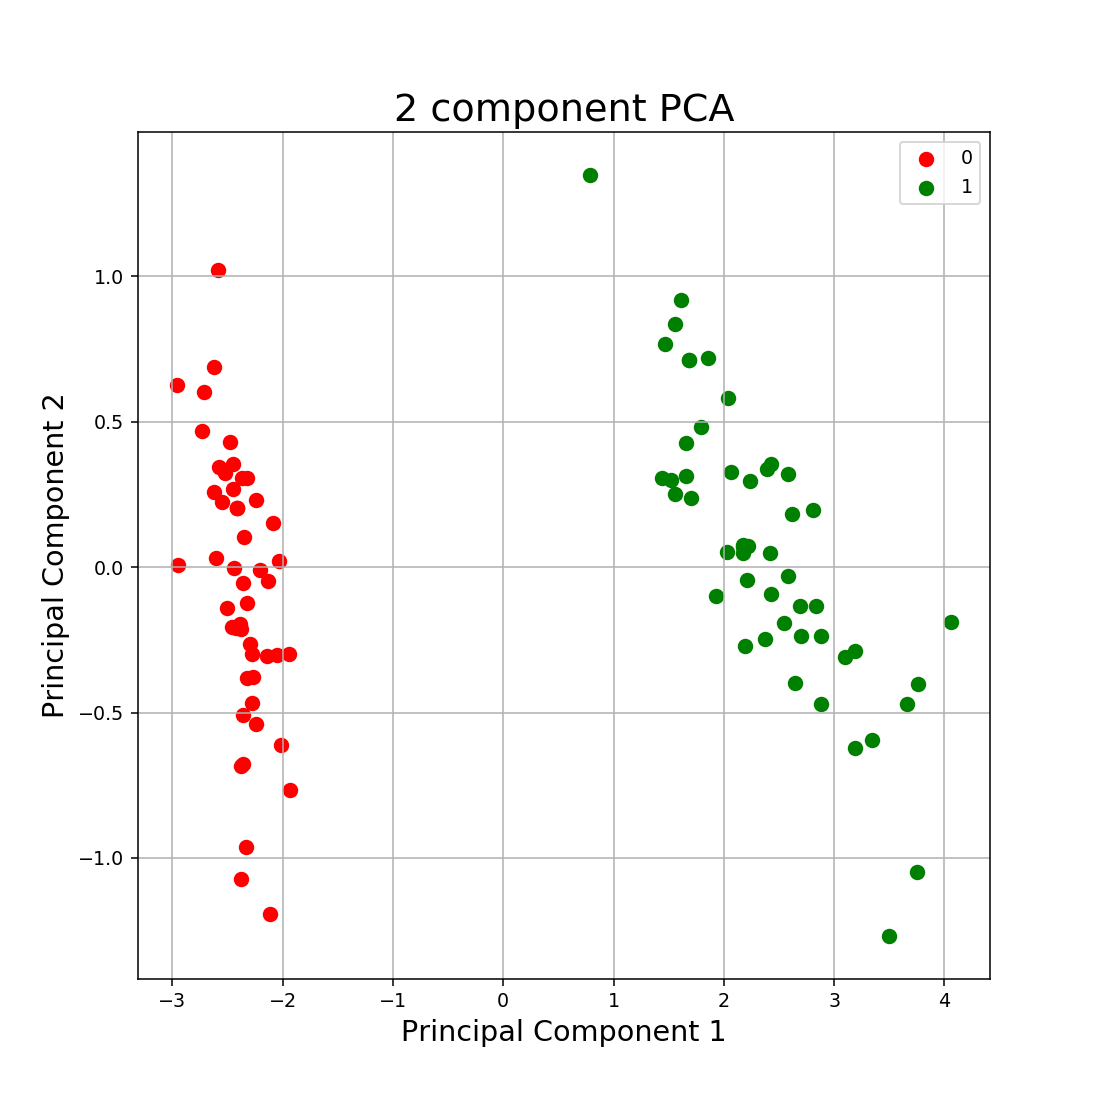

In [14]:
#Testing PCA, prep etc


#loading file and preprocessing it
csv_file = 'iris-species\Iris.csv'
data = pd.read_csv(csv_file)
data= data.sample(frac=1)
print(data.shape)
prep = Iris_binary_prep()
prepca = PCA_prep(2)
data = prep(data)
data = prepca(data)

#ploting
targets = data.iloc[:,-1]
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = data['Species'] == target
    ax.scatter(data.loc[indicesToKeep, 0]
               , data.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [22]:
# We can compose the prep with Compose

csv_file = 'iris-species\Iris.csv'
data = pd.read_csv(csv_file)
prep = Iris_binary_prep()

prepyj = Yeo_Johnson_prep(True)
composed = transforms.Compose([prep,prepyj])
data = composed(data)
print(data)


    SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  Species
0       -0.696991      0.759988      -1.041920     -1.061914      0.0
1       -0.974080     -0.435251      -1.041920     -1.061914      0.0
2       -1.271337      0.060300      -1.148979     -1.061914      0.0
3       -1.428270     -0.184346      -0.942028     -1.061914      0.0
4       -0.833152      0.982771      -1.041920     -1.061914      0.0
5       -0.314696      1.623254      -0.760260     -0.528637      0.0
6       -1.428270      0.532164      -1.041920     -0.757198      0.0
7       -0.833152      0.532164      -0.942028     -1.061914      0.0
8       -1.760450     -0.692793      -1.041920     -1.061914      0.0
9       -0.974080     -0.184346      -0.942028     -1.538984      0.0
10      -0.314696      1.200760      -0.942028     -1.061914      0.0
11      -1.120045      0.532164      -0.848390     -1.061914      0.0
12      -1.120045     -0.435251      -1.041920     -1.538984      0.0
13      -1.936465   

C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


In [15]:
# checking the get_nfeatures while preprocessing

csv_file = 'iris-species\Iris.csv'
prep1 = Iris_binary_prep()
prep2 = Polynomial_prep(degree = 2)
prep = transforms.Compose([prep1,prep2])
dataset = GenericDataset(csv_file, preprocessing = prep)
dataset.get_nfeatures()

C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


15

In [16]:
#making an highly entangling layer

def stronglayer(slparam, n_wires, r=1):
    slparam = math.pi * slparam

    qml.RX(slparam[0,0], wires = 0)
    qml.RY(slparam[1,0], wires = 0)
    qml.RZ(slparam[2,0], wires = 0)
    for i in range(1,n_wires):

        qml.RX(slparam[0,i], wires = i)
        qml.RY(slparam[1,i], wires = i)
        qml.RZ(slparam[2,i], wires = i)
        qml.CNOT(wires=[i, i-1])
    qml.CNOT(wires=[0, n_wires-1])

In [17]:
#Hybrid Quantum Classifier
class HQC(nn.Module):
    def __init__(self,device, n_wires, CE_layers, n_qfeatures, n_QClayers):
        super(HQC, self).__init__()
        self.device = device
        self.n_wires =n_wires
        self.mode = torch.tensor(1, dtype = torch.uint8)
        self.n_qfeatures = n_qfeatures #dimension of the output of CE
        
        #dimension of the Quantum Encoder (QE)
        self.n_QElayers = math.ceil(self.n_qfeatures/n_wires)
        print('self.n_QElayers', self.n_QElayers)
        self.to_pad = self.n_QElayers*n_wires - self.n_qfeatures
        print('self.to_pad',self.to_pad)
        assert self.to_pad == 0,"CE exit dim is not a multiple of n_wires"
        
        #number of layer in the Quantum Classifier (QC)
        self.n_QClayers = n_QClayers 
        #CE define a classical neural network that preprocess the data before sending them to the Quantum encoder (In my experiment I keep it to identity)
        self.CE = nn.Sequential(*CE_layers)
        #QE define the parameters to be optimized in the QE
        self.QE_optvar = torch.nn.Parameter(torch.randn((self.n_QElayers, 2, n_wires), requires_grad =True))
        #QC define the parameters to be optimized in the QC
        self.QC_optvar = torch.nn.Parameter(torch.randn((self.n_QClayers, 3, n_wires), requires_grad =True))
        
    
    # I define 2 mode train and eval, It enables me to stop the computation after the QE and have look to state.
    def trainmode_(self,): 
        self.mode = torch.tensor(1, dtype = torch.uint8)
        
    def evalmode_(self,): 
        self.mode = torch.tensor(0, dtype = torch.uint8)
        
    def forward(self, x):

        #CE        
        #x = x.view(-1, self.num_flat_features(x)) #usefull when batched!
        x = self.CE(x)
        #QE 
        
        
        #x =F.pad(x, (0,self.to_pad)) #add zeros to my data so that it fits in my encoder.
        
        x = x.view((self.n_QElayers, 1, self.n_wires)) #slice the data for the differe,t layers of the encoders

        QE_param = torch.cat((x,self.QE_optvar,), dim = 1)

        # if we are in training_mode
        if(self.mode):
            #QE 

            @qml.qnode(self.device, interface='torch')
            def circuit(x,QE_param,QC_optvar):
                #QE 
                for j in range(self.n_QElayers):
                    QE_layparam = QE_param[j,:,:] #take the parameters of the jth encoding layer
                    stronglayer(QE_layparam,r=1, n_wires = self.n_wires) #encode them
                for i in range(self.n_QClayers):
                    QC_layparam = QC_optvar[i,:,:] #take the parameters of the ith classifying layers
                    stronglayer(QC_layparam,r=1, n_wires = self.n_wires) #classifies
                return qml.expval.PauliZ(0)
            
        else:
            #the same but we stop after the encoding
            @qml.qnode(self.device, interface='torch')
            def circuit(x,QE_param,QC_optvar):
                #QE 
                for j in range(self.n_QElayers):
                    QE_layparam = QE_param[j,:,:]
                    stronglayer(QE_layparam,r=1, n_wires = self.n_wires)
                return qml.expval.PauliZ(0)
        

        #QC
        out = 0.5*(1+(circuit(x,QE_param,self.QC_optvar)))
        out = out.unsqueeze(0)
        return torch.cat((out,1-out,))#0.5*(1+(circuit(x,QE_param,self.QC_optvar)))

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        print('numflat',num_features)
        return num_features

In [22]:


def train(model,train_dataset,test_dataset,loss_fn,n_epoch=5):
    #model.trainmode_()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    valid_losses = []
    valid_acc = []
    train_losses = []
    train_loss_store = torch.zeros(1)
    for e in range(n_epoch):
        print('n_epoch',e)
        for i in range(len(train_dataset)):
            #print('train_data i',i)
            
            #eval
            if (i == 0):
                score = torch.zeros(1)
                valid_loss_store = torch.zeros(1)
                
                with torch.no_grad():
                    for j in range(len(test_dataset)):
                        #print('evalmode', j)
                        sample = test_dataset[j]
                        X, label = sample['X'], sample['label']
                        output = model(X)
                        output = torch.unsqueeze(output,0)
                        label = torch.unsqueeze(label,0)

                        loss = loss_fn(output, label)
                        valid_loss_store += loss
                        
                        _, predicted = torch.max(output.data, 1)
                        #print('predicted', predicted.data, 'label', label.data)
                        score += predicted.eq(label).float()
                score = score/len(test_dataset)
                print('acc', score)
                valid_acc += [score.item()]
                valid_loss_store = valid_loss_store/len(test_dataset)
                print('valid_loss_store',valid_loss_store)
                valid_losses += [valid_loss_store.item()]
                train_loss_store = train_loss_store/20
                print('train_loss_store',train_loss_store)
                train_losses += [train_loss_store.item()]
                train_loss_store = torch.zeros(1)
                    


                    
            sample = train_dataset[i]
            X, label = sample['X'], sample['label']
            #print(label)

            optimizer.zero_grad()
            output = model(X)

            
            
            #artificially adding the batch dimention to make it compatible with the loss function
            output = torch.unsqueeze(output,0)
            label = torch.unsqueeze(label,0)
            #output = torch.log(output)#postprocessing(output)
            
            loss = loss_fn(output, label)
            #loss = - label*torch.log(output) - (1-label)*torch.log(1-output)
            train_loss_store += loss
            
            #print('loss', loss)
            loss.backward()
#             for name, param in model.named_parameters():
#                 #print(param)
#                 print(i,name,'gradient odg',param.grad.data.sum())
            optimizer.step()
    return train_losses, valid_losses, valid_acc
            
            


In [23]:
dev = qml.device('default.qubit', wires=4)
CE_layers = [nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 8), nn.ReLU(), nn.Linear(8, 4), nn.ReLU()]

#define an HQC
model = HQC(dev,4, CE_layers,4,2)

#Checking that pytorch is going to apply its gradient descent over all the parameters 
par= model.parameters()
for name, param in model.named_parameters():
    print(name,param)

self.n_QElayers 1
self.to_pad 0
QE_optvar Parameter containing:
tensor([[[-0.5640, -1.1170, -2.0927,  0.0937],
         [ 0.5979,  0.9597,  0.4950,  1.1126]]], requires_grad=True)
QC_optvar Parameter containing:
tensor([[[ 0.7444,  0.7721, -0.7922, -0.6896],
         [ 1.1229,  0.4316,  1.8486,  0.0302],
         [-0.9925, -1.0966, -1.4890,  1.1613]],

        [[-0.2637,  0.5881, -1.7570, -1.1764],
         [-0.0147, -0.1727,  1.7529, -0.8170],
         [ 1.2927,  0.1370,  0.9051,  0.8073]]], requires_grad=True)
CE.0.weight Parameter containing:
tensor([[ 0.2307, -0.3196, -0.3429, -0.1143],
        [ 0.3392, -0.4290,  0.2221,  0.4178],
        [ 0.2944,  0.2297,  0.0750,  0.3436],
        [-0.0492,  0.3245, -0.3173,  0.0436],
        [ 0.1289,  0.1774, -0.4170, -0.4305],
        [-0.1008, -0.2398,  0.1422,  0.4478],
        [-0.2885, -0.2494,  0.0295,  0.3694],
        [ 0.2935, -0.4298,  0.3735, -0.3030]], requires_grad=True)
CE.0.bias Parameter containing:
tensor([-0.0507, -0.3215,  

In [24]:
#Dataset
csv_file = 'iris-species\Iris.csv'
prep1 = Iris_binary_prep()
poly = Polynomial_prep(degree = 2)

prep = transforms.Compose([prep1,poly])
full_dataset = GenericDataset(csv_file, preprocessing = prep)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# define the dataset and give me the number of features after preprocessing
print(full_dataset.get_nfeatures())



15


C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [25]:
%matplotlib notebook
import matplotlib.pyplot as plt


#dev = qml.device('forest.qvm', device='4q', noisy=True)
dev = qml.device('default.qubit', wires=4)
CE_layers = [nn.Linear(15, 16), nn.ReLU(), nn.Linear(16, 8), nn.ReLU(), nn.Linear(8, 4), nn.ReLU()]
model = HQC(dev,4, CE_layers, n_qfeatures = 4, n_QClayers = 2)


#TRAIN
n_epoch = 5
loss_fn = torch.nn.CrossEntropyLoss() 
idx, train_losses, valid_losses, valid_acc = train(model,train_dataset, test_dataset,loss_fn)


self.n_QElayers 1
self.to_pad 0
n_epoch 0


C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


acc tensor([0.6000])
valid_loss_store tensor([0.6526])
train_loss_store tensor([0.])
n_epoch 1
acc tensor([0.9500])
valid_loss_store tensor([0.5708])
train_loss_store tensor([2.5001], grad_fn=<DivBackward0>)


KeyboardInterrupt: 

In [ ]:
print(idx)

In [ ]:
print(valid_acc)

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(valid_losses)

In [ ]:
plt.plot(valid_acc)

# Test classical for comparaison


In [26]:
#Dataset
csv_file = 'iris-species\Iris.csv'
prep = Iris_binary_prep()
full_dataset = GenericDataset(csv_file, transform=None, preprocessing = prep)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

full_dataset.get_nfeatures()

C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


4

In [33]:
CE_layers = [nn.Linear(4, 2), nn.Softmax()]
model = nn.Sequential(*CE_layers)

In [34]:
#TRAIN
n_epoch = 5
loss_fn = torch.nn.CrossEntropyLoss()

        

        
def train(model,train_dataset,test_dataset,loss_fn,n_epoch=5):
    #model.trainmode_()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
    valid_losses = []
    valid_acc = []
    train_losses = []
    train_loss_store = torch.zeros(1)
    idx = []
    for e in range(n_epoch):
        print('n_epoch',e)
        for i in range(len(train_dataset)):
            #print('train_data i',i)
            
            #eval
            if (i%20 == 0):
                idx +=[i]
                score = torch.zeros(1)
                valid_loss_store = torch.zeros(1)
                
                with torch.no_grad():
                    for j in range(len(test_dataset)):
                        #print('evalmode', j)
                        sample = test_dataset[j]
                        X, label = sample['X'], sample['label']
                        output = model(X)
                        output = torch.unsqueeze(output,0)
                        label = torch.unsqueeze(label,0)
                        loss = loss_fn(output, label)
                        valid_loss_store += loss
                        
                        _, predicted = torch.max(output.data, 1)
                        score += predicted.eq(label).float()
                score = score/len(test_dataset)
                print('acc', score)
                valid_acc += [score.item()]
                valid_loss_store = valid_loss_store/len(test_dataset)
                print('valid_loss_store',valid_loss_store)
                valid_losses += [valid_loss_store.item()]
                train_loss_store = train_loss_store/20
                print('train_loss_store',train_loss_store)
                train_losses += [train_loss_store.item()]
                train_loss_store = torch.zeros(1)
                    


                    
            sample = train_dataset[i]
            X, label = sample['X'], sample['label']
            #print(label)

            optimizer.zero_grad()
            output = model(X)

            #artificially adding the batch dimention to make it compatible with the loss function
            output = torch.unsqueeze(output,0)
            label = torch.unsqueeze(label,0)
            loss = loss_fn(output, label)
            train_loss_store += loss


            loss.backward()
            optimizer.step()
            b = list(model.parameters())[0]

    return idx, train_losses, valid_losses, valid_acc
            
            

    
idx, train_losses, valid_losses, valid_acc = train(model,train_dataset, test_dataset,loss_fn)

n_epoch 0
acc tensor([0.4500])
valid_loss_store tensor([0.8356])
train_loss_store tensor([0.])
acc tensor([0.4500])
valid_loss_store tensor([0.8001])
train_loss_store tensor([0.7791], grad_fn=<DivBackward0>)
acc tensor([0.4500])
valid_loss_store tensor([0.6813])
train_loss_store tensor([0.7337], grad_fn=<DivBackward0>)
acc tensor([0.9500])
valid_loss_store tensor([0.5518])
train_loss_store tensor([0.6027], grad_fn=<DivBackward0>)
n_epoch 1
acc tensor([1.])
valid_loss_store tensor([0.4785])
train_loss_store tensor([0.5290], grad_fn=<DivBackward0>)
acc tensor([1.])
valid_loss_store tensor([0.4358])
train_loss_store tensor([0.4658], grad_fn=<DivBackward0>)
acc tensor([1.])
valid_loss_store tensor([0.4160])
train_loss_store tensor([0.4283], grad_fn=<DivBackward0>)
acc tensor([1.])
valid_loss_store tensor([0.3959])
train_loss_store tensor([0.4046], grad_fn=<DivBackward0>)
n_epoch

C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


 2
acc tensor([1.])
valid_loss_store tensor([0.3828])
train_loss_store tensor([0.3953], grad_fn=<DivBackward0>)
acc tensor([1.])
valid_loss_store tensor([0.3731])
train_loss_store tensor([0.3772], grad_fn=<DivBackward0>)
acc tensor([1.])
valid_loss_store tensor([0.3680])
train_loss_store tensor([0.3710], grad_fn=<DivBackward0>)
acc tensor([1.])
valid_loss_store tensor([0.3617])
train_loss_store tensor([0.3635], grad_fn=<DivBackward0>)
n_epoch 3
acc tensor([1.])
valid_loss_store tensor([0.3568])
train_loss_store tensor([0.3627], grad_fn=<DivBackward0>)
acc tensor([1.])
valid_loss_store tensor([0.3527])
train_loss_store tensor([0.3531], grad_fn=<DivBackward0>)
acc tensor([1.])
valid_loss_store tensor([0.3504])
train_loss_store tensor([0.3517], grad_fn=<DivBackward0>)
acc tensor([1.])
valid_loss_store tensor([0.3476])
train_loss_store tensor([0.3478], grad_fn=<DivBackward0>)
n_epoch 4
acc tensor([1.])
valid_loss_store tensor([0.3450])
train_loss_store tensor([0.3486], grad_fn=<DivBackward